# Procesamiento de lenguaje natural
## Desafío 4

# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
import gdown
import zipfile
import os

import re
import subprocess

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from ipywidgets import IntProgress


import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 22.2MB/s]


In [3]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario


In [4]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [7]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer


# Tokenizo los textos de entrada
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

# Diccioanrio de palabras a índices para las palabras de entrada
word2idx_inputs = input_tokenizer.word_index
print('Palabras en el vocabulario:', len(word2idx_inputs))

# Calculo la longitud máxima de las secuencias de entrada
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)



Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [9]:
# Tokenizo los textos de salida
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

# Diccionario de palabras a índices para las palabras de salida
word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

# Calculo la longitud máxima de las secuencias de salida
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


In [10]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

# Padding de las secuencias de entrada
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print('Decoder input sequences shape:', decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print('Decoder output sequences shape:', decoder_output_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
Decoder input sequences shape: (6033, 10)
Decoder output sequences shape: (6033, 10)


In [11]:
# Preparación de los targets: Cada target es one-hot encoded para la longitud del vocabulario de salida
decoder_targets = np.zeros(
    (len(input_sentences), max_out_len, num_words_output),
    dtype='float32'
)

In [12]:
for i, seq in enumerate(decoder_output_sequences):
    for t, word in enumerate(seq):
        if word != 0:  # No incluir el padding en los targets
            decoder_targets[i, t, word] = 1

print('Decoder targets shape:', decoder_targets.shape)

Decoder targets shape: (6033, 10, 1807)


### 3 - Preparar los embeddings
Utilizar los embeddings de FastText para transformar los tokens de entrada en vectores

In [13]:
url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
output = 'fasttext.pkl'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa
From (redirected): https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&confirm=t&uuid=8e67b29d-65f0-4de7-bef5-d8bd57ebff2d
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:45<00:00, 63.9MB/s]


'fasttext.pkl'

In [14]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = './glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    #WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    WORD_TO_VEC_MODEL_TXT_PATH = './wiki-news-300d-1M.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [16]:
# Emplear los embeddings de Fasttext
model_embeddings = FasttextEmbeddings()

In [17]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [18]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1799, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [19]:
max_input_len

9

In [20]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 9, 300)         │        539,700 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 10, 128)        │        231,296 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │        219,648 │ embedding[0][0]        │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 10, 128),      │        131,584 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 1807)       │        233,103 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,355,331 (5.17 MB)

 Trainable params: 815,631 (3.11 MB)

 Non-trainable params: 539,700 (2.06 MB)

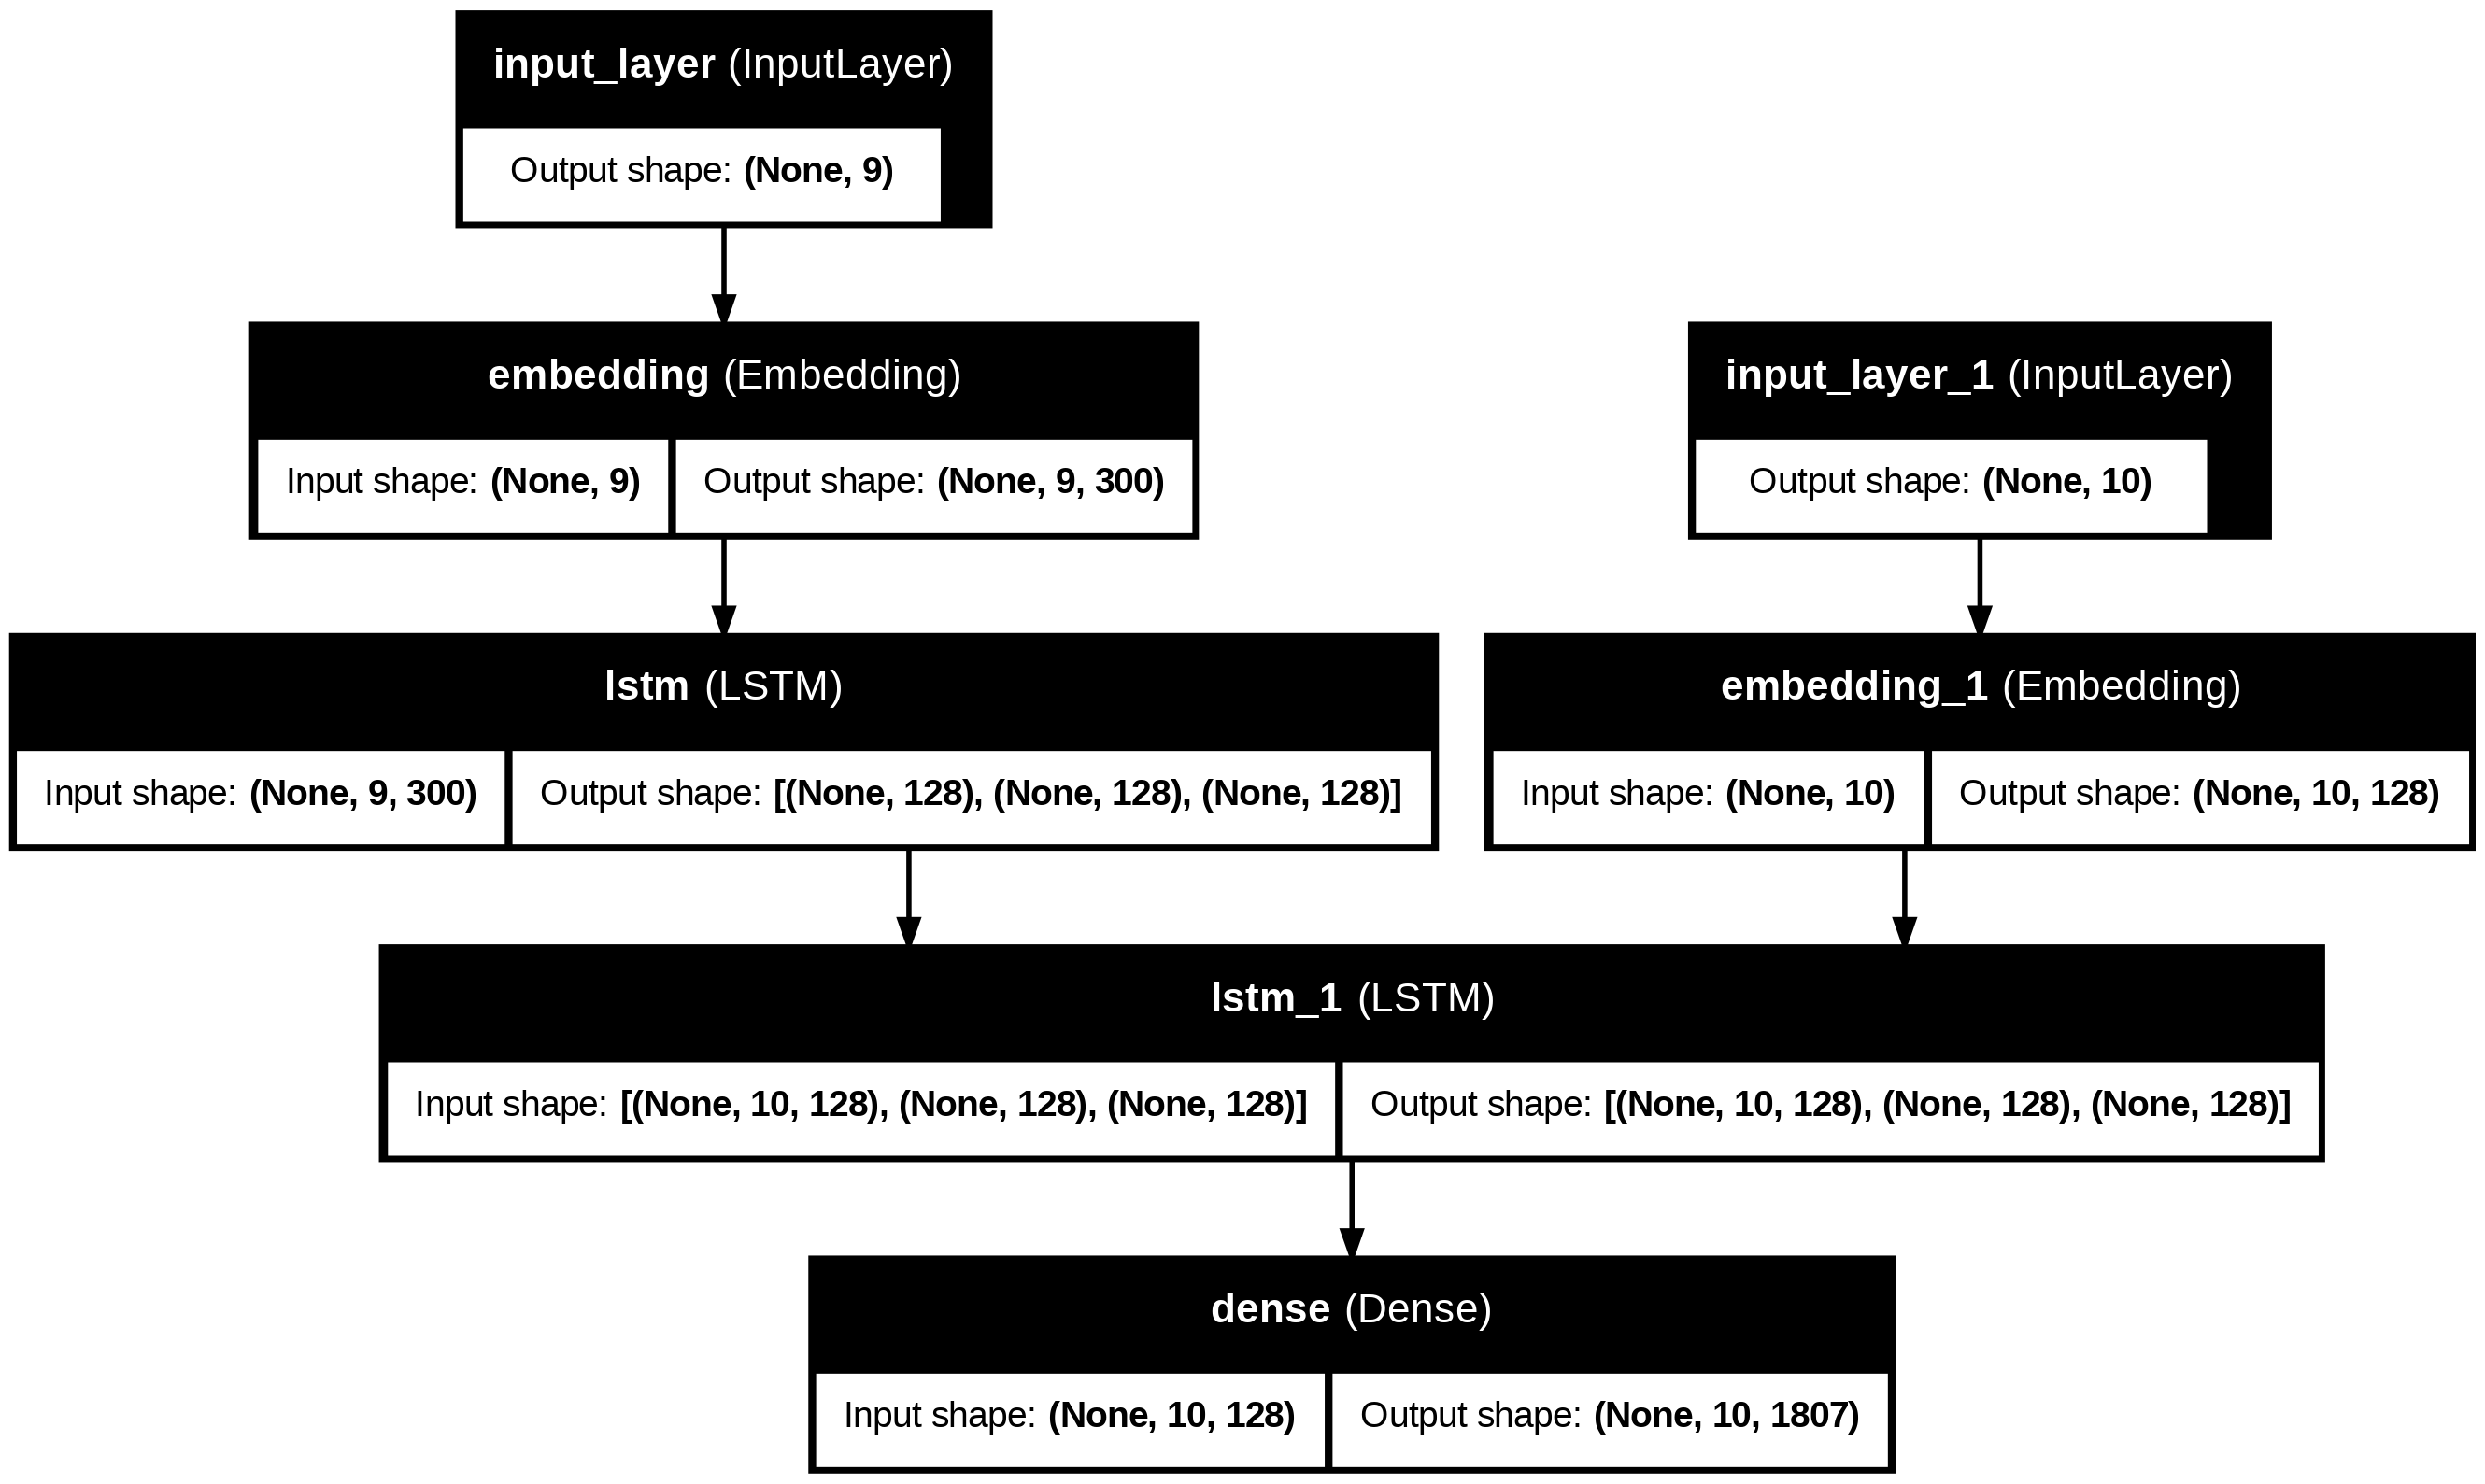

In [21]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

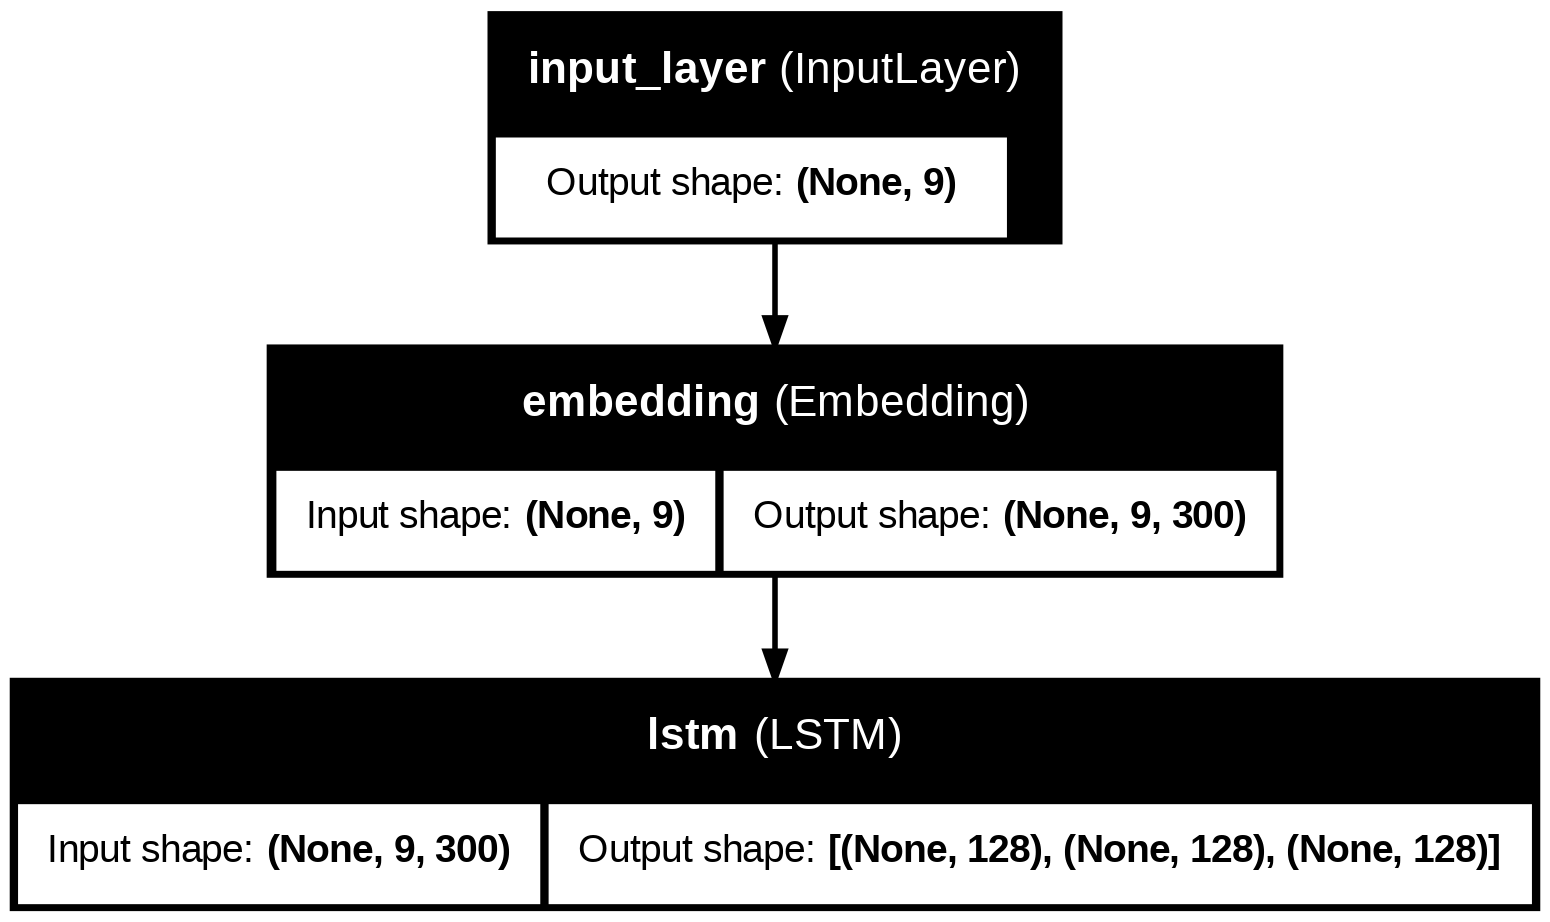

In [22]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

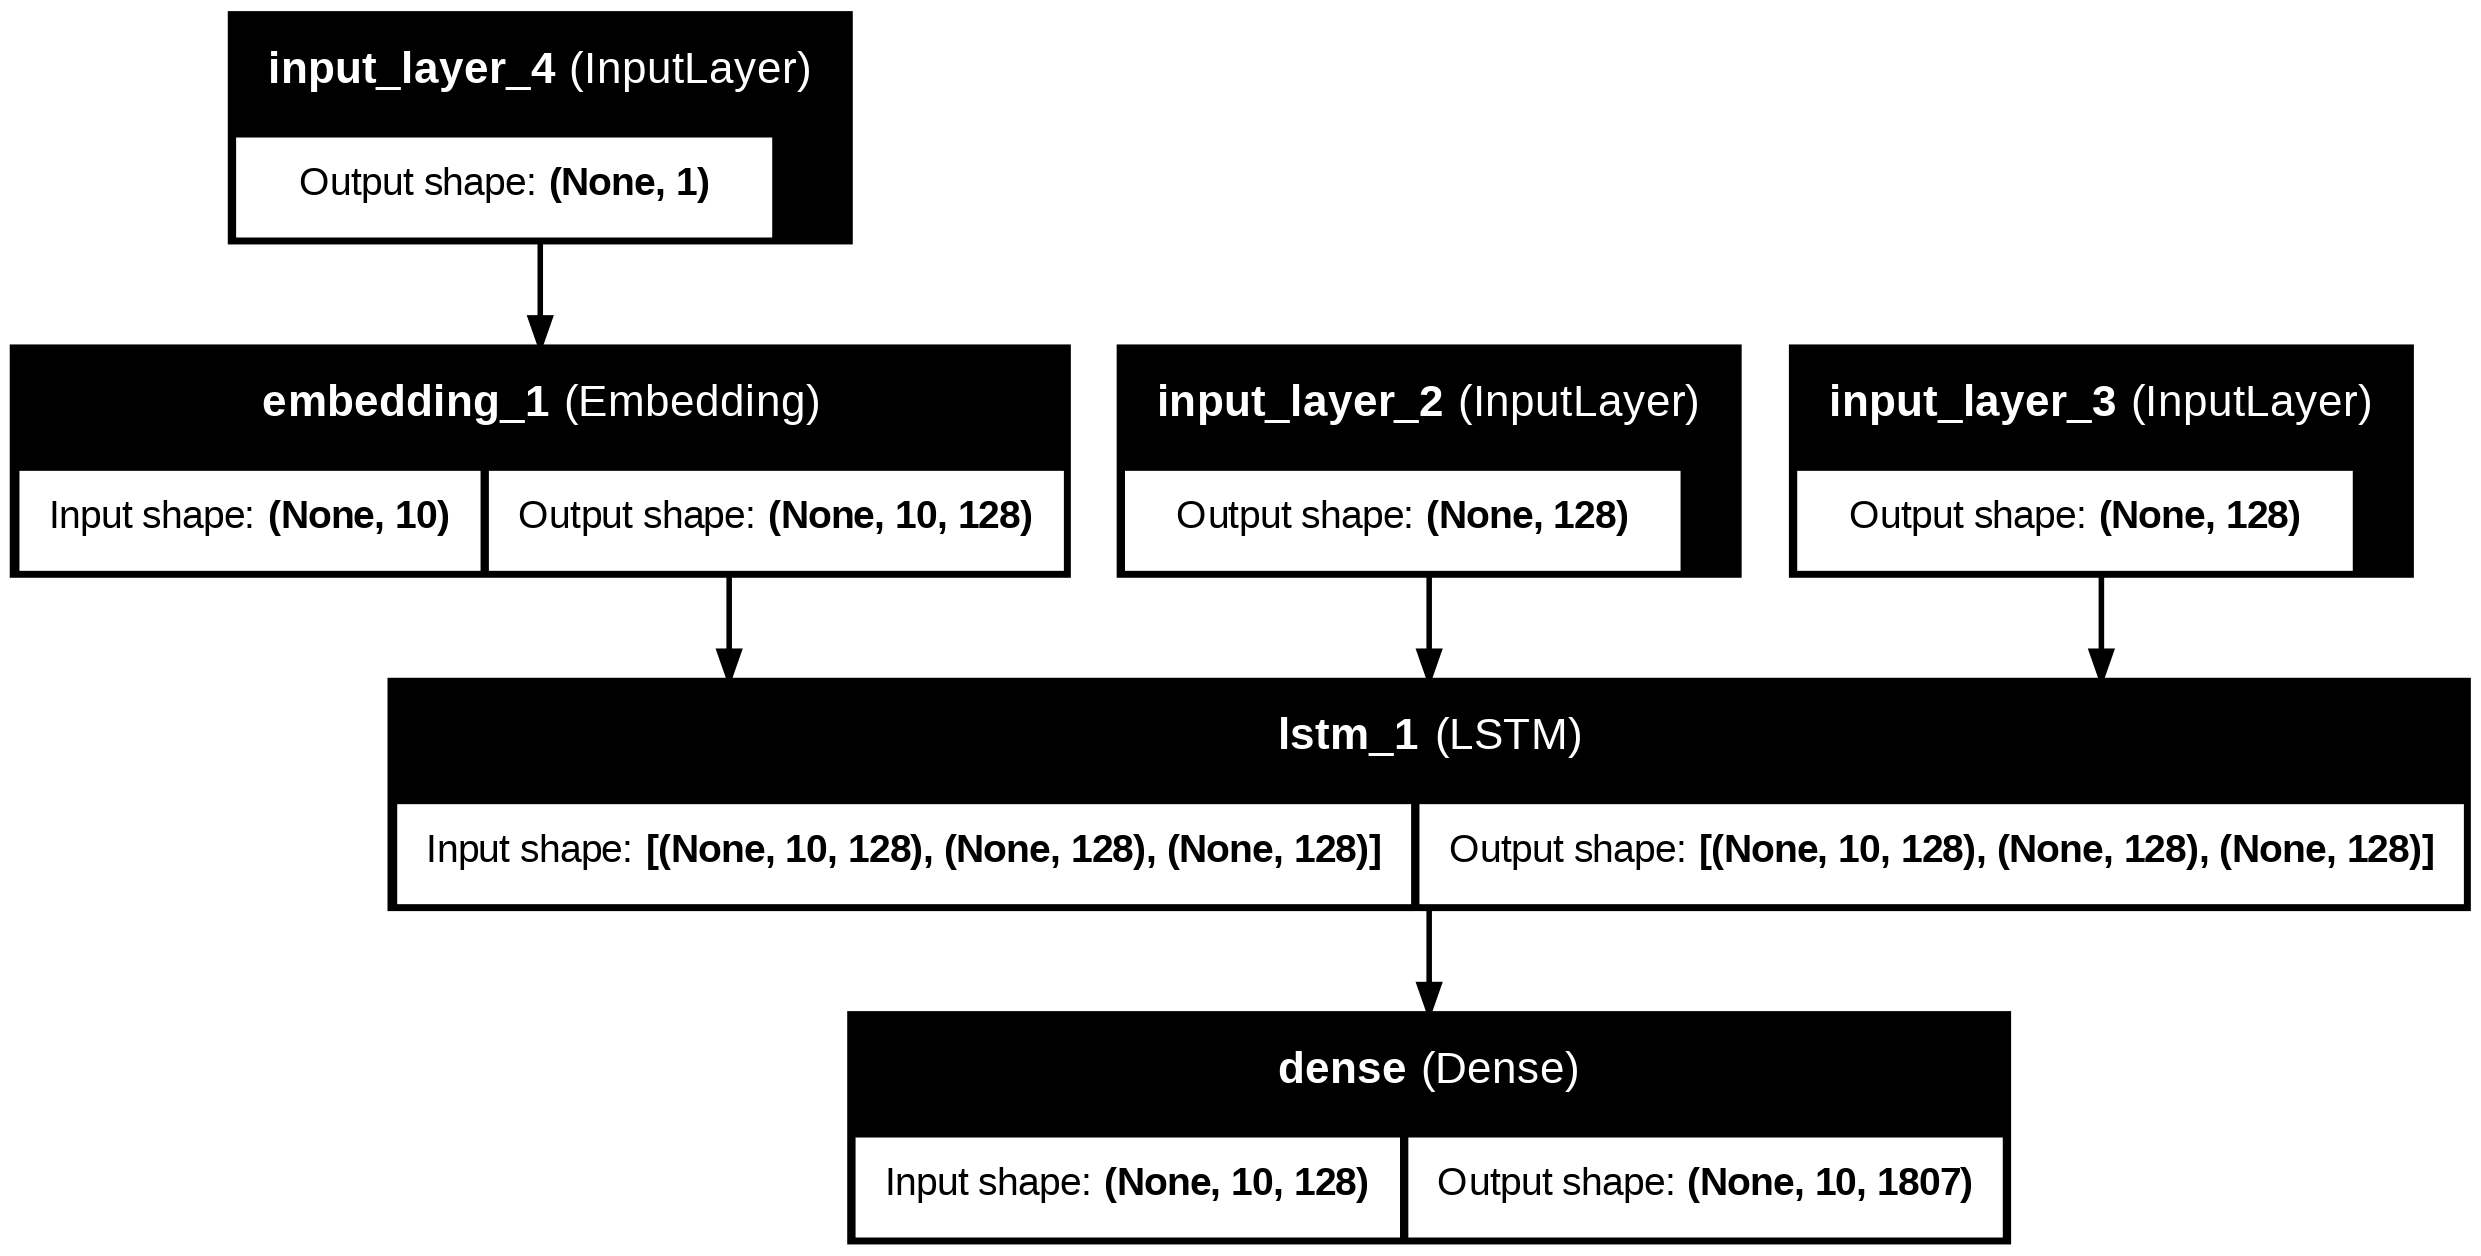

In [23]:
# Modelo solo decoder (para realizar inferencia)

# Definir el modelo del decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

use 40 epochs para evitar tanto overfitting

In [24]:
hist = model.fit(
      [encoder_input_sequences, decoder_input_sequences],
      decoder_targets,
      epochs=40,
      validation_split=0.2)

Epoch 1/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.1029 - loss: 2.7838 - val_accuracy: 0.1240 - val_loss: 2.2788
Epoch 2/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1248 - loss: 2.1751 - val_accuracy: 0.1251 - val_loss: 2.2244
Epoch 3/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1305 - loss: 2.1044 - val_accuracy: 0.1340 - val_loss: 2.1718
Epoch 4/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1418 - loss: 2.0474 - val_accuracy: 0.1394 - val_loss: 2.1183
Epoch 5/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1519 - loss: 1.9871 - val_accuracy: 0.1509 - val_loss: 2.0779
Epoch 6/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1637 - loss: 1.9163 - val_accuracy: 0.1590 - val_loss: 2.0470
Epoch 7/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1807 - loss: 1.8807 - val_accuracy: 0.1678 - val_loss: 2.0088
Epoch 8/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1888 - loss: 1.8043 - val_accuracy

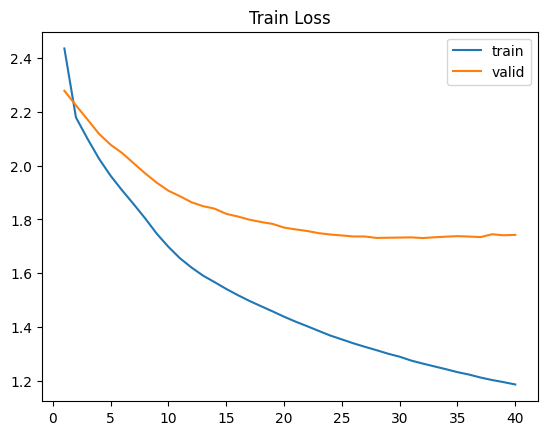

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
# loss baja progresivamente
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.title('Train Loss')
plt.show()

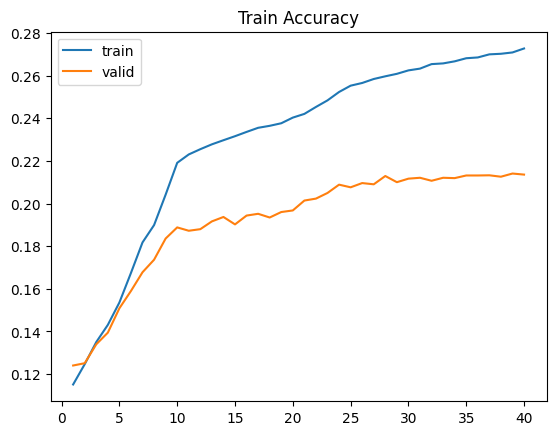

In [26]:
# Entrenamiento
# accuracy sube progresivamente
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.title('Train Accuracy')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [27]:
# Armar los conversores de índice a palabra:
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

In [28]:
def respuesta_sentence(input_seq):
    # Se transforma la secuencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentence <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [29]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = respuesta_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
-
Input: living u
Response: what do you do for a living


In [34]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = respuesta_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-
Input: tell me about yourself
Response: i am a vegan


In [38]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = respuesta_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
-
Input: hello how are you today 
Response: i am fine


Deje esa prueba porque respondió bien 🙂 jaja, pero si probamos con otra cosa...

In [40]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = respuesta_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
-
Input: i want to see you
Response: i love to read


no da tan buenos resultados ☹

Preguntas interesantes:

In [41]:
input_test = "Do you read?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
response = respuesta_sentence(encoder_sequence_test)
print('Response:', response)

Input: Do you read?
Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  3  2 23]]
Input: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Response: i do not do for a living


In [42]:
input_test = "Do you have any pet?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
response = respuesta_sentence(encoder_sequence_test)
print('Response:', response)

Input: Do you have any pet?
Representacion en vector de tokens de ids [3, 2, 16, 31, 252]
Padding del vector: [[  0   0   0   0   3   2  16  31 252]]
Input: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Response: i like to read


In [44]:
input_test = "Where are you from?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
response = respuesta_sentence(encoder_sequence_test)
print('Response:', response)

Input: Where are you from?
Representacion en vector de tokens de ids [52, 7, 2, 39]
Padding del vector: [[ 0  0  0  0  0 52  7  2 39]]
Input: Where are you from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Response: i am a vegan


Conclusiones

A pesar de no ser el mejor modelo, en algunos casos da respuestas muy buenas como las que deje de ejemplo anteriormente.

Otra cosa interesante es que en las preguntas dejadas para el desafio:

Do you read?
Do you have any pet?
Where are you from?

Las primeras dos se pregunta en primera persona y el modelo responde en primera persona tambien, en la tercera si da error ya que no tiene nada que ver con la pregunta.

Probablemente se requiera complejizar el modelo, tener mas datos para el entrenamiento y/o reentrenar los embeddings.


### Modificar modelo

In [59]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder_lstm1 = LSTM(n_units, return_sequences=True, dropout=0.2)
encoder_lstm2 = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs_aux = encoder_lstm1(encoder_inputs_x)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs_aux)

encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm1 = LSTM(n_units, return_sequences=True, dropout=0.2)
decoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs_aux= decoder_lstm1(decoder_inputs_x, initial_state=encoder_states)
decoder_outputs, _, _ = decoder_lstm2(decoder_outputs_aux)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 9, 300)         │        539,700 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_18 (LSTM)            │ (None, 9, 128)         │        219,648 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 10, 128)        │        231,296 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_19 (LSTM)            │ [(None, 128), (None,   │        131,584 │ lstm_18[0][0]          │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ (None, 10, 128)        │        131,584 │ embedding_11[0][0],    │
│                           │                        │                │ lstm_19[0][1],         │
│                           │                        │                │ lstm_19[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ [(None, 10, 128),      │        131,584 │ lstm_20[0][0]          │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 10, 1807)       │        233,103 │ lstm_21[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,618,499 (6.17 MB)

 Trainable params: 1,078,799 (4.12 MB)

 Non-trainable params: 539,700 (2.06 MB)

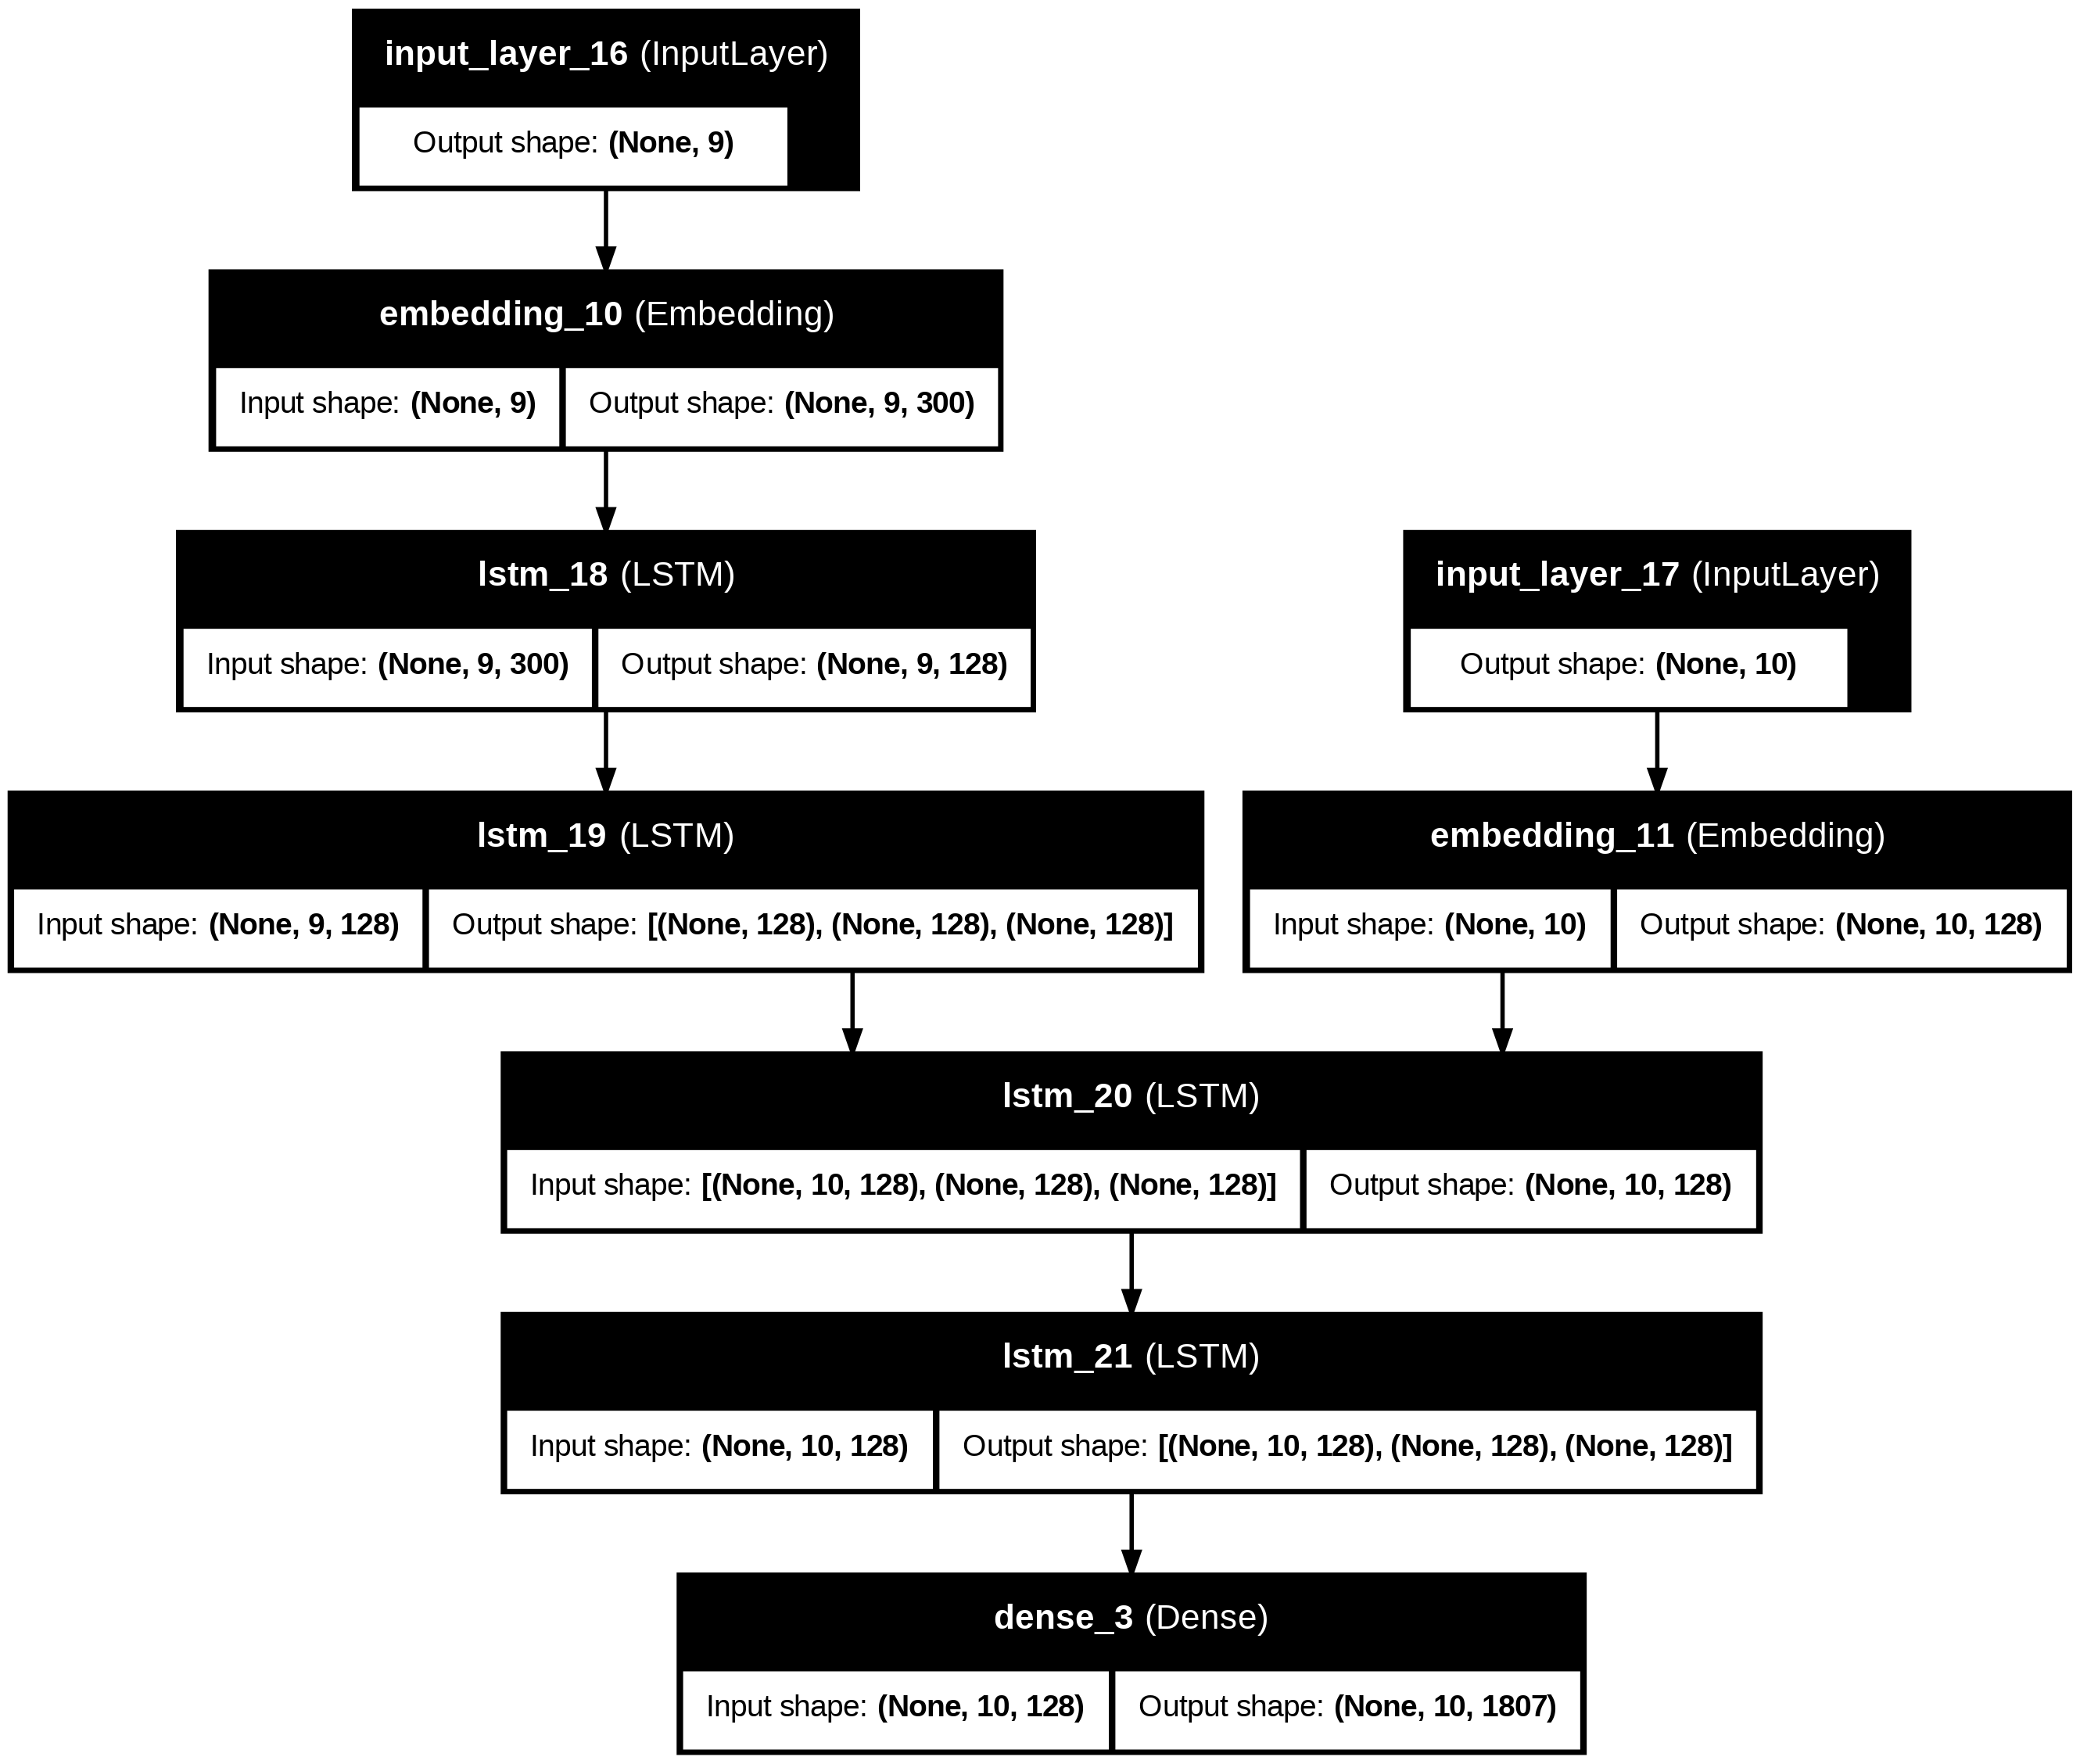

In [60]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='2LSTMmodel_plot.png', show_shapes=True, show_layer_names=True)

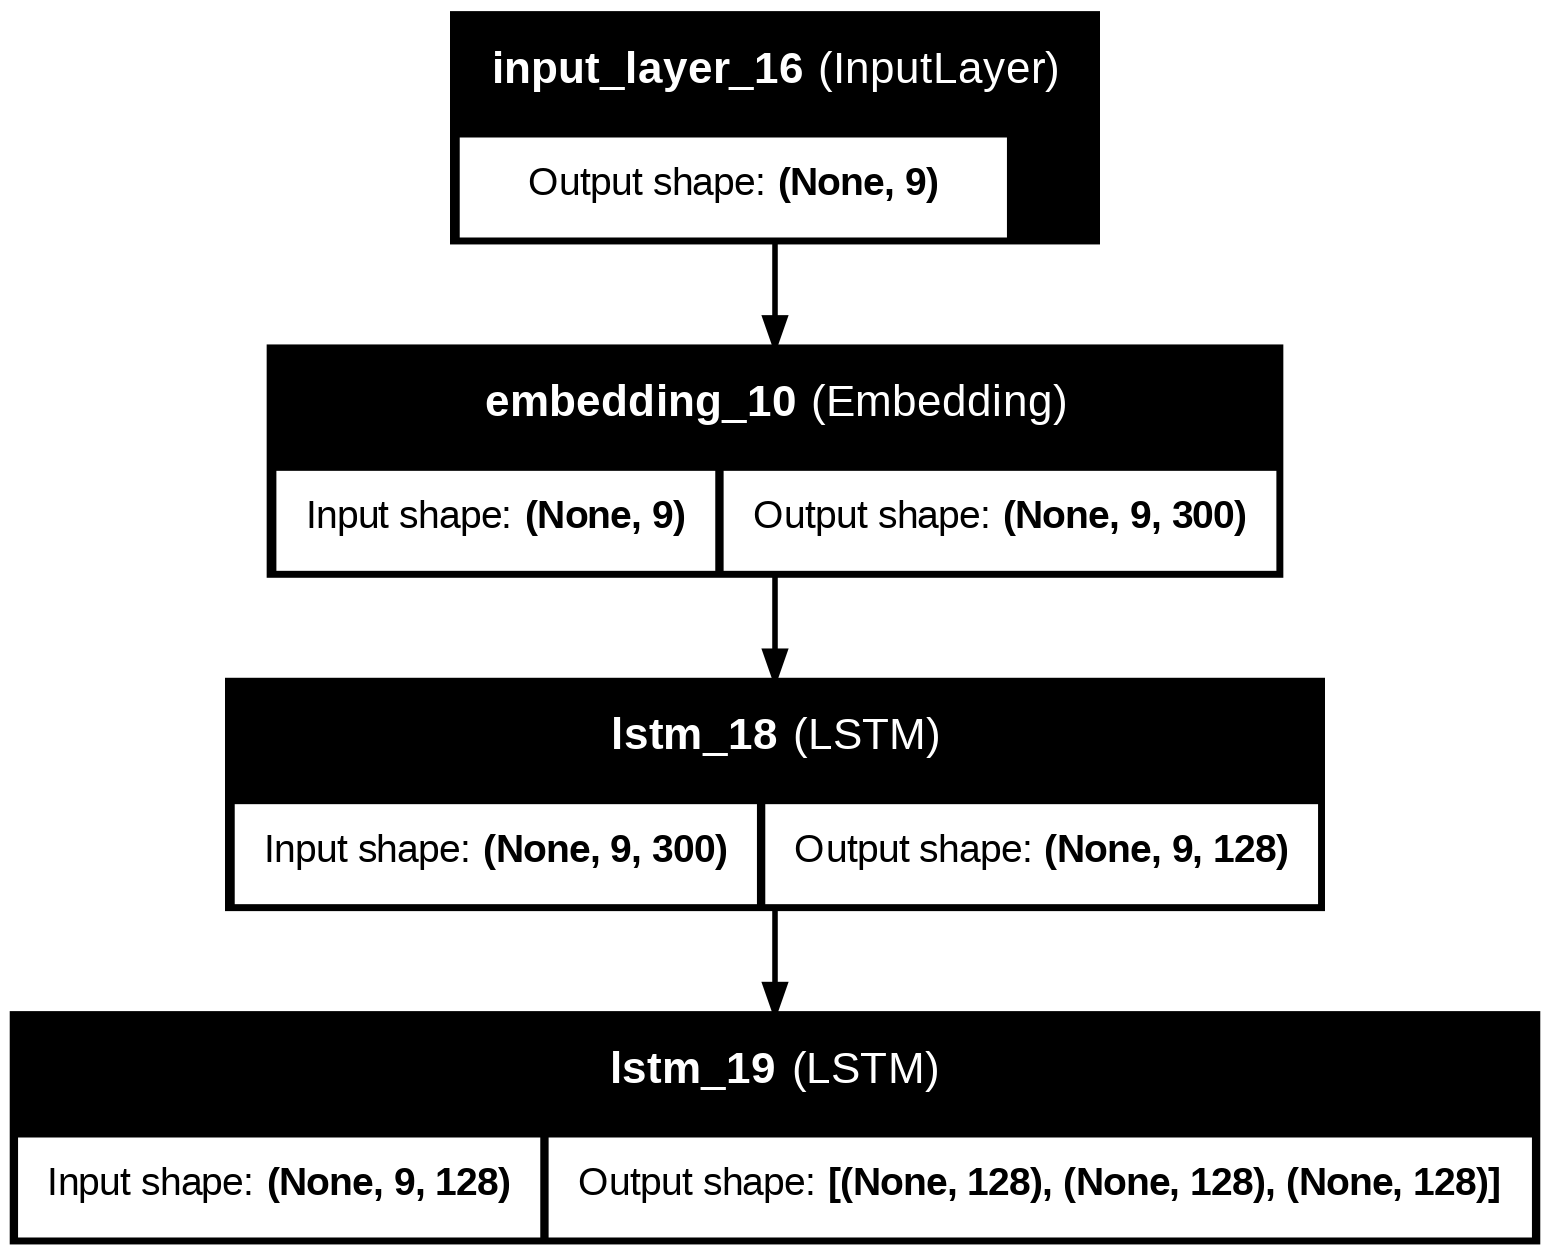

In [61]:
# Modelo solo encoder pero con 2 LSTM

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='2LSTMencoder_plot.png', show_shapes=True, show_layer_names=True)

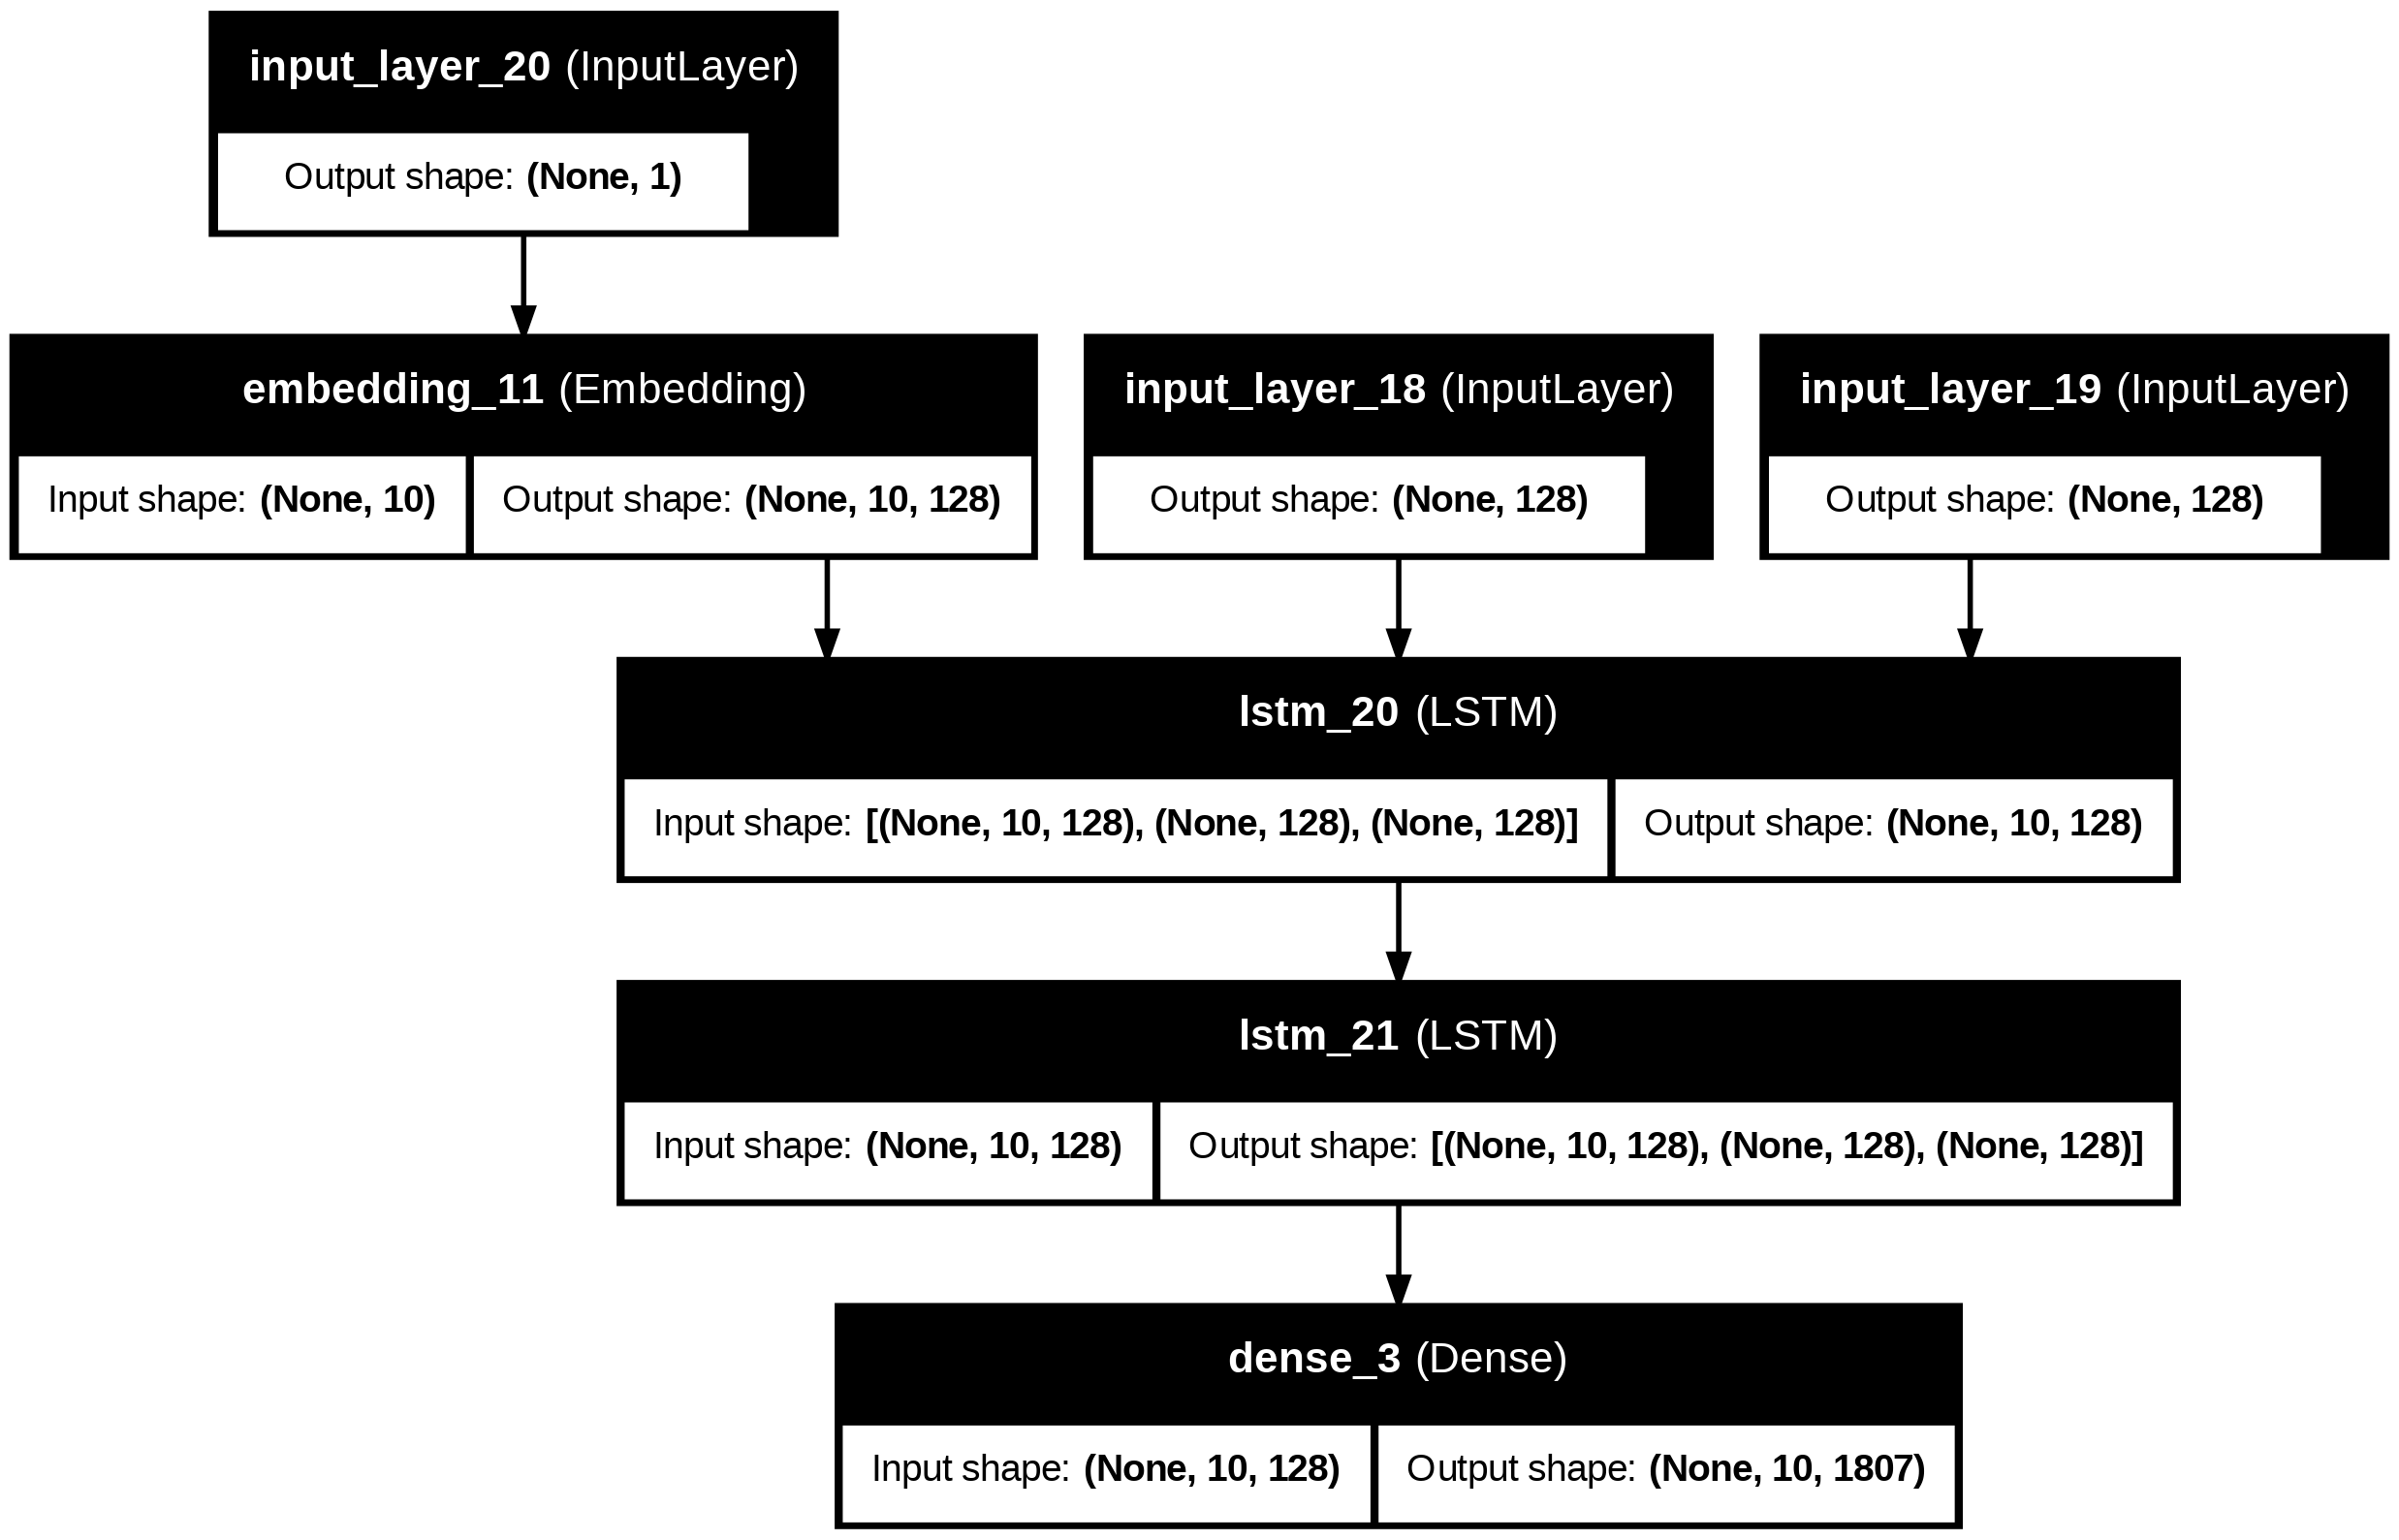

In [62]:
# Modelo solo decoder (para realizar inferencia)

# Definir el modelo del decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs_aux = decoder_lstm1(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_outputs, state_h, state_c = decoder_lstm2(decoder_outputs_aux)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='2LSTMdecoder_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
hist = model.fit(
      [encoder_input_sequences, decoder_input_sequences],
      decoder_targets,
      epochs=60,
      validation_split=0.2)

Epoch 1/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0956 - loss: 2.8606 - val_accuracy: 0.1000 - val_loss: 2.3849
Epoch 2/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1039 - loss: 2.3378 - val_accuracy: 0.1240 - val_loss: 2.3424
Epoch 3/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1250 - loss: 2.2693 - val_accuracy: 0.1240 - val_loss: 2.3136
Epoch 4/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1245 - loss: 2.2471 - val_accuracy: 0.1240 - val_loss: 2.2965
Epoch 5/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1236 - loss: 2.2238 - val_accuracy: 0.1240 - val_loss: 2.2888
Epoch 6/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1247 - loss: 2.2048 - val_accuracy: 0.1240 - val_loss: 2.2782
Epoch 7/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1222 - loss: 2.1833 - val_accuracy: 0.1240 - val_loss: 2.2678
Epoch 8/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1327 - loss: 2.1707 - val_accu

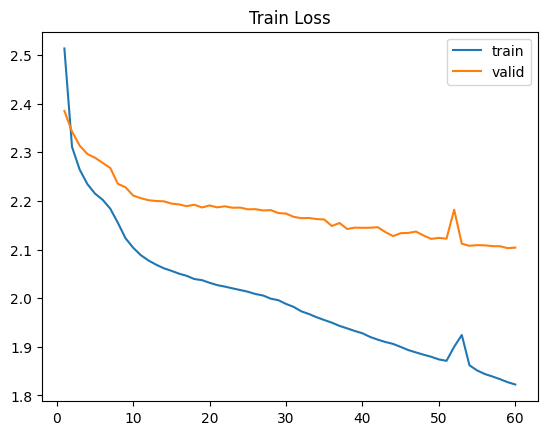

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
# loss baja progresivamente
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.title('Train Loss')
plt.show()

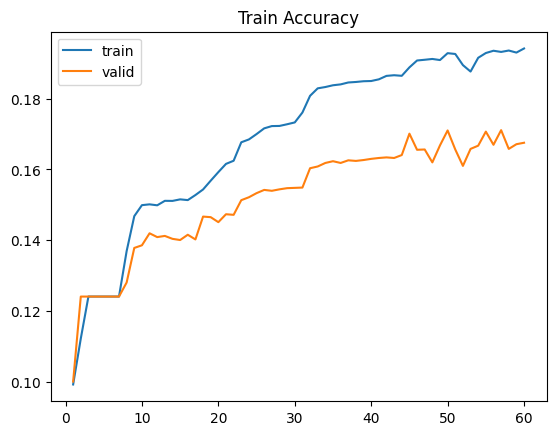

In [65]:
# Entrenamiento
# accuracy sube progresivamente
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.title('Train Accuracy')
plt.show()

In [66]:
def respuesta_sentence(input_seq):
    # Se transforma la secuencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentence <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [67]:
input_test = "Do you read?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
response = respuesta_sentence(encoder_sequence_test)
print('Response:', response)

Input: Do you read?
Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  3  2 23]]
Input: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Response: i i do i do i do i i do


In [68]:
input_test = "Do you have any pet?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
response = respuesta_sentence(encoder_sequence_test)
print('Response:', response)

Input: Do you have any pet?
Representacion en vector de tokens de ids [3, 2, 16, 31, 252]
Padding del vector: [[  0   0   0   0   3   2  16  31 252]]
Input: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Response: i do i i i i i i i i


In [69]:
input_test = "Where are you from?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
response = respuesta_sentence(encoder_sequence_test)
print('Response:', response)

Input: Where are you from?
Representacion en vector de tokens de ids [52, 7, 2, 39]
Padding del vector: [[ 0  0  0  0  0 52  7  2 39]]
Input: Where are you from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Response: i i do i what what i i i i


El modelo colocando 2 LSTM no mejoró las respuestas.